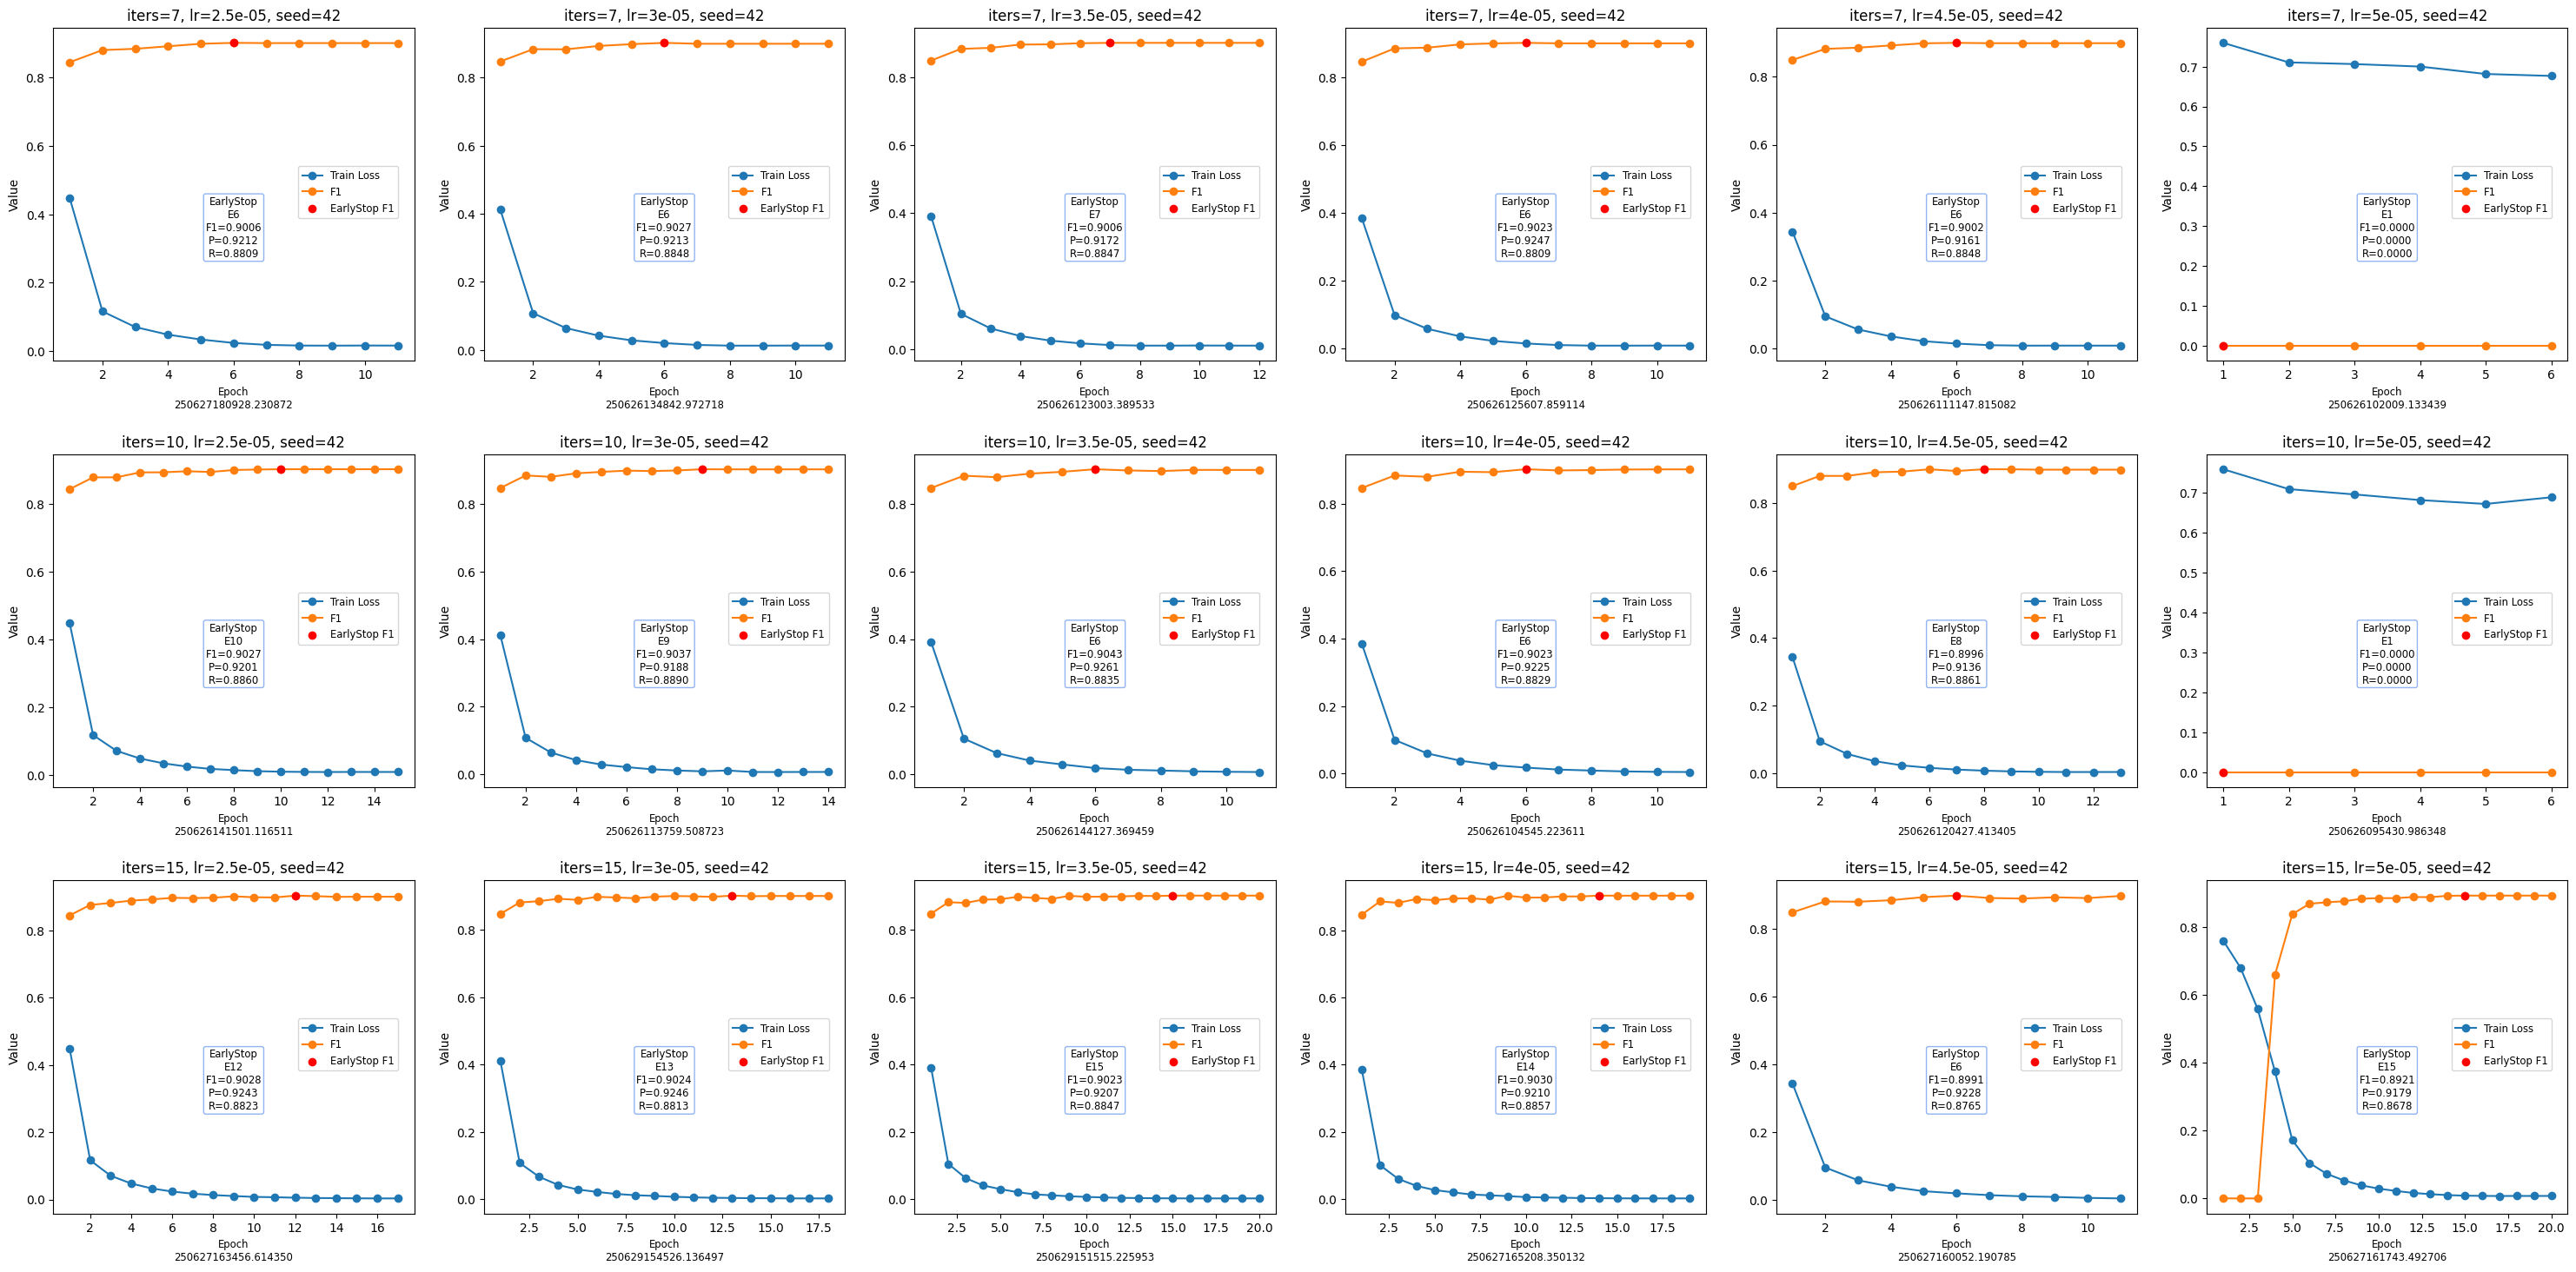


========= Top 3 experiments (by Early Stopping, patience=5) =========
1. Directory:       250626144127.369459
   Config: iters=10, lr=3.5e-05, seed=42, epoch=6
   Valid Precision: 0.9261
   Valid Recall:    0.8835
   Valid F1:        0.9043
2. Directory:       250626113759.508723
   Config: iters=10, lr=3e-05, seed=42, epoch=9
   Valid Precision: 0.9188
   Valid Recall:    0.8890
   Valid F1:        0.9037
3. Directory:       250627165208.350132
   Config: iters=15, lr=4e-05, seed=42, epoch=14
   Valid Precision: 0.9210
   Valid Recall:    0.8857
   Valid F1:        0.9030


In [8]:
import os
import json
import yaml
import math
import matplotlib.pyplot as plt

# ========== Config ==========
experiments_dir = '../experiments1/gp_bert_large'
patience = 5

# ========== Helper function ==========
def get_cfg_info(dpath):
    cfg_path = os.path.join(dpath, 'config.yaml')
    cfg = yaml.safe_load(open(cfg_path))
    # Get total iterations & learning rate
    if 'lr_scheduler' in cfg:
        iters = cfg['lr_scheduler']['total_iters']
        lr = cfg['optimizer']['lr']
    else:
        iters = cfg['train']['lr_scheduler']['total_iters']
        lr = cfg['train']['optimizer']['lr']
    # Get seed: priority experiment.seed > top-level seed > train.seed
    seed = None
    if 'experiment' in cfg and 'seed' in cfg['experiment']:
        seed = cfg['experiment']['seed']
    elif 'seed' in cfg:
        seed = cfg['seed']
    elif 'train' in cfg and 'seed' in cfg['train']:
        seed = cfg['train']['seed']
    return iters, lr, seed

# ========== Scan valid experiment subdirectories ==========
dir_infos = []
for d in sorted(os.listdir(experiments_dir)):
    dpath = os.path.join(experiments_dir, d)
    mpath = os.path.join(dpath, 'metrics.json')
    if not (d[0].isdigit() and os.path.isdir(dpath) and os.path.exists(mpath)):
        continue
    with open(mpath) as f:
        recs = [json.loads(line) for line in f if line.strip()]
    if any(r.get('mode') == 'eval' for r in recs):
        iters, lr, seed = get_cfg_info(dpath)
        dir_infos.append((d, iters, lr, seed))
# Sort by iters, lr, seed (None last)
dir_infos_sorted = sorted(
    dir_infos,
    key=lambda x: (x[1], x[2], x[3] if x[3] is not None else float('inf'))
)

# ========== Plotting setup ==========
valid_dirs = [x[0] for x in dir_infos_sorted]
n = len(valid_dirs)
cols = 6
rows = math.ceil(n / cols)
fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 5))
axes = axes.flatten()

# Collect EarlyStop info for each experiment
esf1_infos = []

for ax, (d, iters, lr, seed) in zip(axes, dir_infos_sorted):
    dpath = os.path.join(experiments_dir, d)
    metrics = [json.loads(line) for line in open(os.path.join(dpath, 'metrics.json')) if line.strip()]
    # Extract epochs
    epochs = sorted({m['epoch'] for m in metrics if m['mode'] == 'train'})
    train_losses = []
    val_f1s = []
    for e in epochs:
        train_losses.append(
            sum(m['loss'] for m in metrics if m['mode'] == 'train' and m['epoch'] == e) /
            max(1, len([m for m in metrics if m['mode'] == 'train' and m['epoch'] == e]))
        )
        f1_list = [m['evaluation/f1'] for m in metrics if m['mode'] == 'eval' and m['epoch'] == e]
        val_f1s.append(f1_list[0] if f1_list else None)

    # Early stopping based on patience
    best_f1_es = -1.0
    patience_counter = 0
    best_epoch_es = epochs[0]
    for i, f1 in enumerate(val_f1s):
        if f1 is not None and f1 > best_f1_es:
            best_f1_es = f1
            best_epoch_es = epochs[i]
            patience_counter = 0
        else:
            patience_counter += 1
        if patience_counter >= patience:
            break

    # Record metrics at best_epoch_es
    es_record = next(m for m in metrics if m['mode'] == 'eval' and m['epoch'] == best_epoch_es)
    vp_es = es_record['evaluation/precision']
    vr_es = es_record['evaluation/recall']
    vf_es = es_record['evaluation/f1']

    # Append this experiment's info
    esf1_infos.append({
        'dir':       d,
        'iters':     iters,
        'lr':        lr,
        'seed':      seed,
        'epoch':     best_epoch_es,
        'precision': vp_es,
        'recall':    vr_es,
        'f1':        vf_es
    })

    # Plot training loss and validation F1
    max_epoch_to_plot = best_epoch_es + patience
    plot_epochs = [e for e in epochs if e <= max_epoch_to_plot]
    plot_train = [train_losses[epochs.index(e)] for e in plot_epochs]
    plot_val = [val_f1s[epochs.index(e)] for e in plot_epochs]

    ax.plot(plot_epochs, plot_train, marker='o', label='Train Loss')
    ax.plot(plot_epochs, plot_val, marker='o', label='F1')
    ax.scatter(best_epoch_es, vf_es, zorder=5, label='EarlyStop F1', color='red')
    ax.annotate(
        f"EarlyStop\nE{best_epoch_es}\nF1={vf_es:.4f}\nP={vp_es:.4f}\nR={vr_es:.4f}",
        xy=(0.5, 0.4), xycoords='axes fraction',
        ha='center', va='center', fontsize='small',
        bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="cornflowerblue", alpha=0.7)
    )
    ax.set_title(f"iters={iters}, lr={lr}, seed={seed}")
    ax.set_xlabel(f'Epoch\n{d}', fontsize='small', labelpad=4)
    ax.set_ylabel('Value')
    ax.legend(loc='upper right', bbox_to_anchor=(0.97, 0.6), fontsize='small')

# Turn off extra axes
for ax in axes[len(valid_dirs):]:
    ax.axis('off')

plt.subplots_adjust(top=0.88, hspace=0.5, wspace=0.3)
plt.tight_layout(pad=2)
plt.show()

# ========== Print Top 3 Experiments ==========
print(f"\n========= Top 3 experiments (by Early Stopping, patience={patience}) =========")
top3 = sorted(esf1_infos, key=lambda x: x['f1'], reverse=True)[:3]
for rank, info in enumerate(top3, start=1):
    print(f"{rank}. Directory:       {info['dir']}")
    print(f"   Config: iters={info['iters']}, lr={info['lr']}, seed={info['seed']}, epoch={info['epoch']}")
    print(f"   Valid Precision: {info['precision']:.4f}")
    print(f"   Valid Recall:    {info['recall']:.4f}")
    print(f"   Valid F1:        {info['f1']:.4f}")


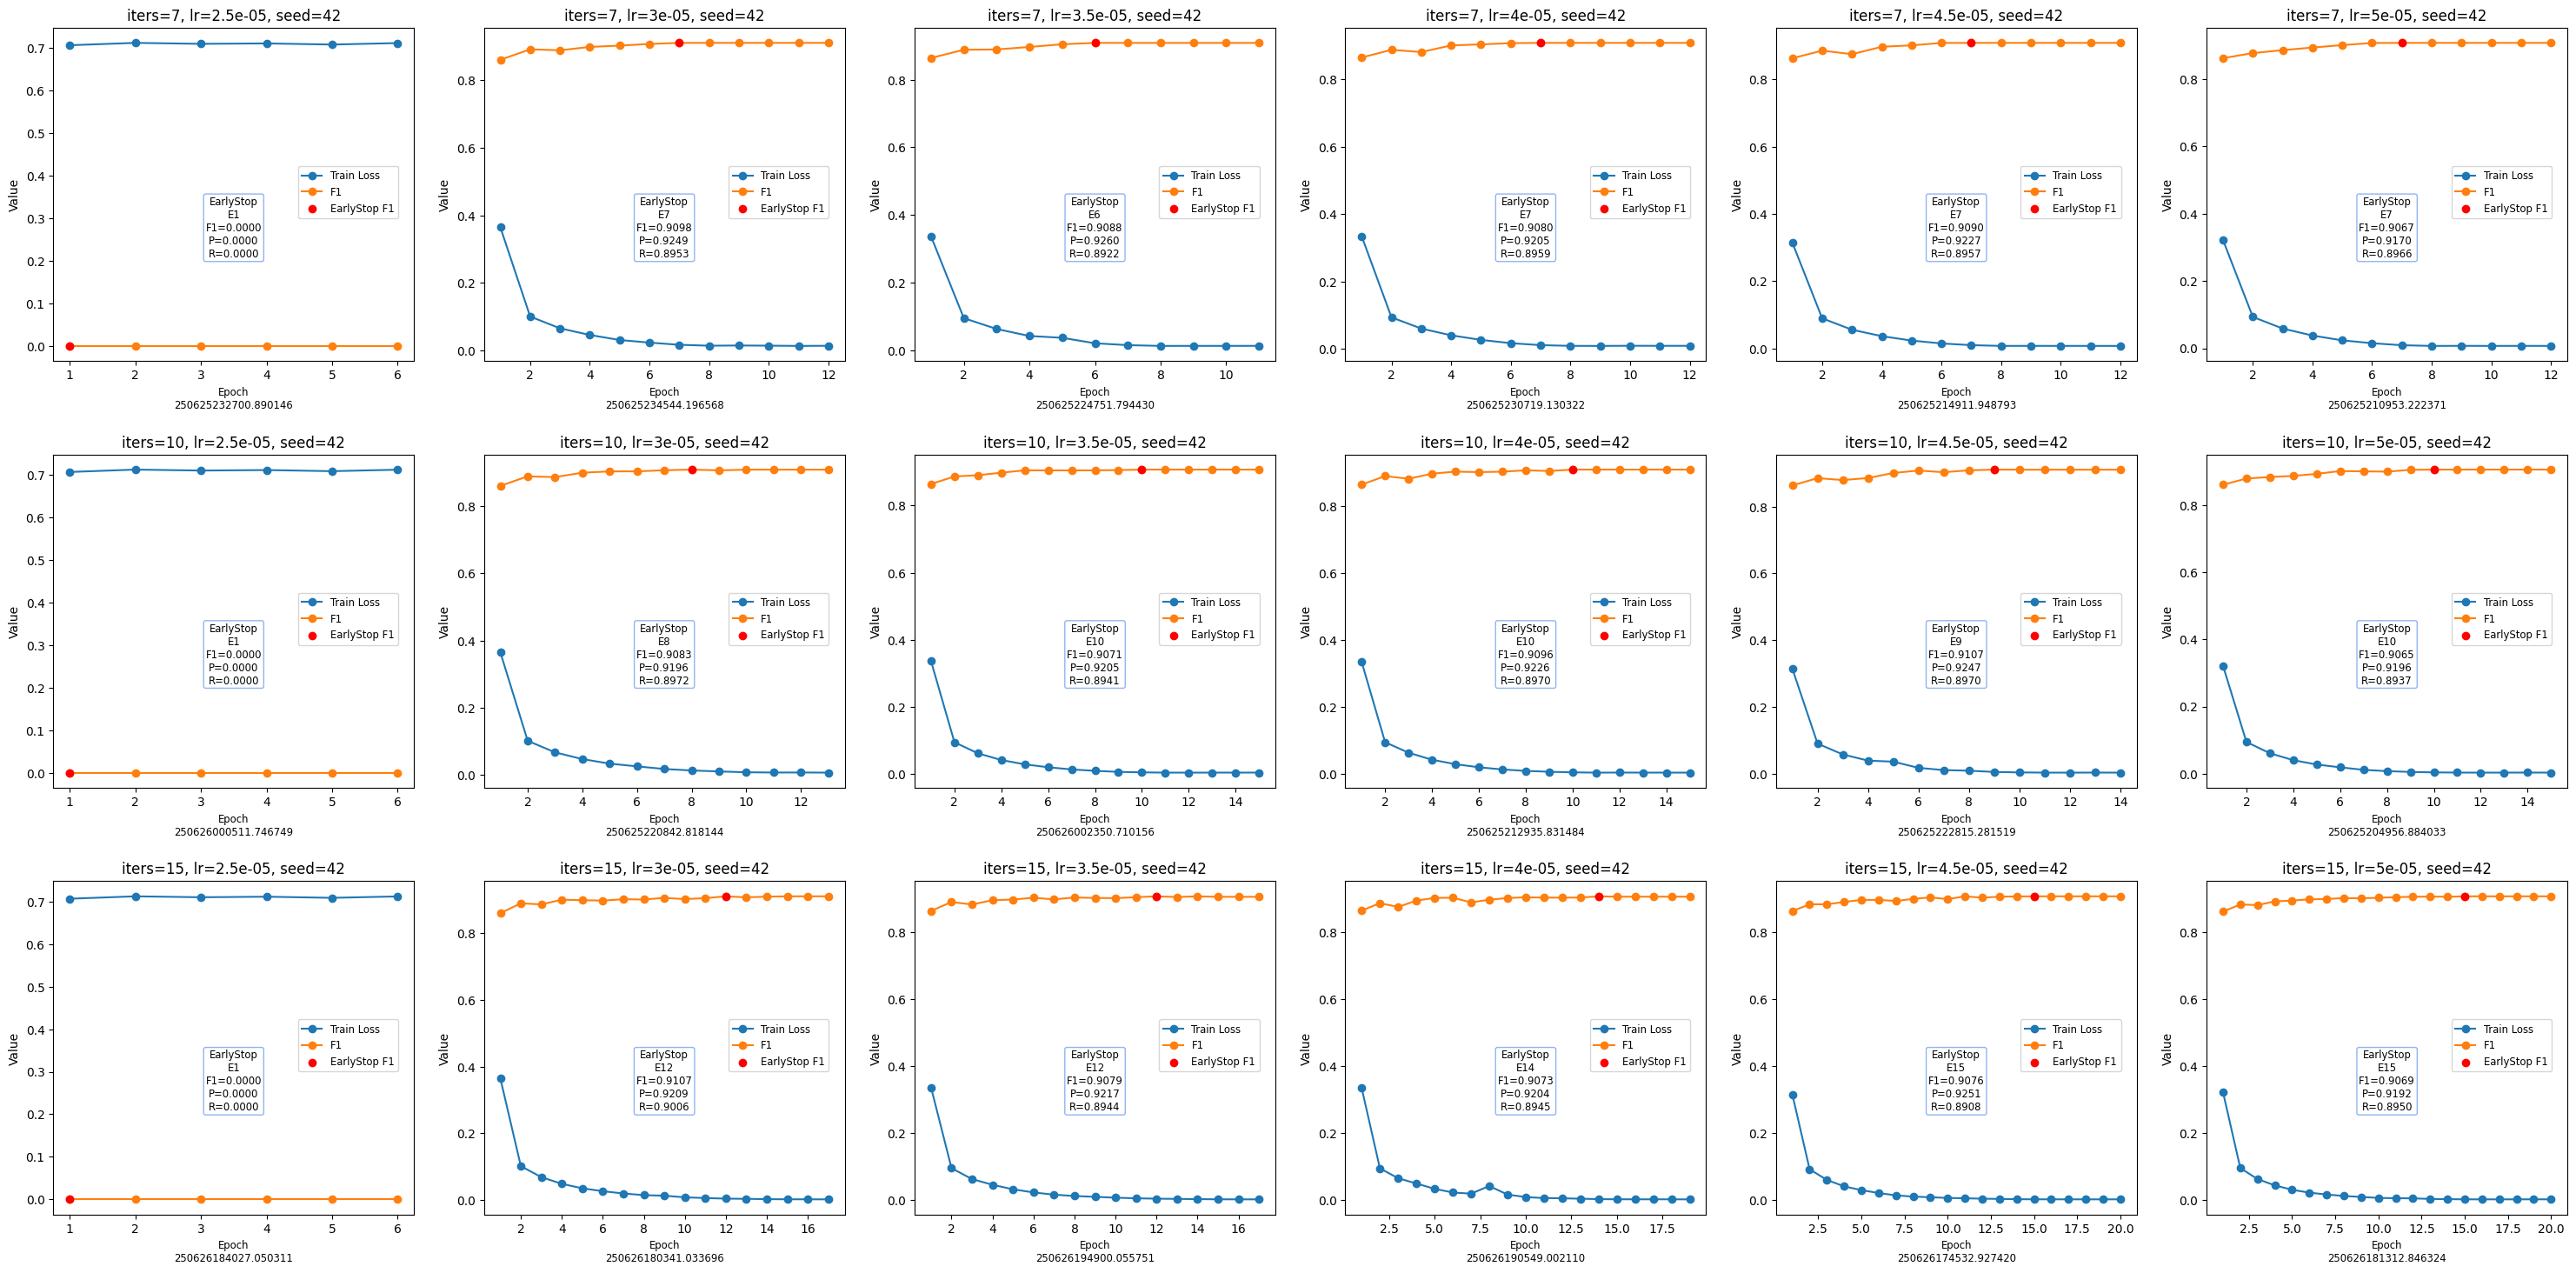


========= Top 3 experiments (by Early Stopping, patience=5) =========
1. Directory:       250625222815.281519
   Config: iters=10, lr=4.5e-05, seed=42, epoch=9
   Valid Precision: 0.9247
   Valid Recall:    0.8970
   Valid F1:        0.9107
2. Directory:       250626180341.033696
   Config: iters=15, lr=3e-05, seed=42, epoch=12
   Valid Precision: 0.9209
   Valid Recall:    0.9006
   Valid F1:        0.9107
3. Directory:       250625234544.196568
   Config: iters=7, lr=3e-05, seed=42, epoch=7
   Valid Precision: 0.9249
   Valid Recall:    0.8953
   Valid F1:        0.9098


In [2]:
import os
import json
import yaml
import math
import matplotlib.pyplot as plt

# ========== Config ==========
experiments_dir = '../experiments1/gp_deberta_large'
patience = 5

# ========== Helper function ==========
def get_cfg_info(dpath):
    cfg_path = os.path.join(dpath, 'config.yaml')
    cfg = yaml.safe_load(open(cfg_path))
    # Get total iterations & learning rate
    if 'lr_scheduler' in cfg:
        iters = cfg['lr_scheduler']['total_iters']
        lr = cfg['optimizer']['lr']
    else:
        iters = cfg['train']['lr_scheduler']['total_iters']
        lr = cfg['train']['optimizer']['lr']
    # Get seed: priority experiment.seed > top-level seed > train.seed
    seed = None
    if 'experiment' in cfg and 'seed' in cfg['experiment']:
        seed = cfg['experiment']['seed']
    elif 'seed' in cfg:
        seed = cfg['seed']
    elif 'train' in cfg and 'seed' in cfg['train']:
        seed = cfg['train']['seed']
    return iters, lr, seed

# ========== Scan valid experiment subdirectories ==========
dir_infos = []
for d in sorted(os.listdir(experiments_dir)):
    dpath = os.path.join(experiments_dir, d)
    mpath = os.path.join(dpath, 'metrics.json')
    if not (d[0].isdigit() and os.path.isdir(dpath) and os.path.exists(mpath)):
        continue
    with open(mpath) as f:
        recs = [json.loads(line) for line in f if line.strip()]
    if any(r.get('mode') == 'eval' for r in recs):
        iters, lr, seed = get_cfg_info(dpath)
        dir_infos.append((d, iters, lr, seed))
# Sort by iters, lr, seed (None last)
dir_infos_sorted = sorted(
    dir_infos,
    key=lambda x: (x[1], x[2], x[3] if x[3] is not None else float('inf'))
)

# ========== Plotting setup ==========
valid_dirs = [x[0] for x in dir_infos_sorted]
n = len(valid_dirs)
cols = 6
rows = math.ceil(n / cols)
fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 5))
axes = axes.flatten()

# Collect EarlyStop info for each experiment
esf1_infos = []

for ax, (d, iters, lr, seed) in zip(axes, dir_infos_sorted):
    dpath = os.path.join(experiments_dir, d)
    metrics = [json.loads(line) for line in open(os.path.join(dpath, 'metrics.json')) if line.strip()]
    # Extract epochs
    epochs = sorted({m['epoch'] for m in metrics if m['mode'] == 'train'})
    train_losses = []
    val_f1s = []
    for e in epochs:
        train_losses.append(
            sum(m['loss'] for m in metrics if m['mode'] == 'train' and m['epoch'] == e) /
            max(1, len([m for m in metrics if m['mode'] == 'train' and m['epoch'] == e]))
        )
        f1_list = [m['evaluation/f1'] for m in metrics if m['mode'] == 'eval' and m['epoch'] == e]
        val_f1s.append(f1_list[0] if f1_list else None)

    # Early stopping based on patience
    best_f1_es = -1.0
    patience_counter = 0
    best_epoch_es = epochs[0]
    for i, f1 in enumerate(val_f1s):
        if f1 is not None and f1 > best_f1_es:
            best_f1_es = f1
            best_epoch_es = epochs[i]
            patience_counter = 0
        else:
            patience_counter += 1
        if patience_counter >= patience:
            break

    # Record metrics at best_epoch_es
    es_record = next(m for m in metrics if m['mode'] == 'eval' and m['epoch'] == best_epoch_es)
    vp_es = es_record['evaluation/precision']
    vr_es = es_record['evaluation/recall']
    vf_es = es_record['evaluation/f1']

    # Append this experiment's info
    esf1_infos.append({
        'dir':       d,
        'iters':     iters,
        'lr':        lr,
        'seed':      seed,
        'epoch':     best_epoch_es,
        'precision': vp_es,
        'recall':    vr_es,
        'f1':        vf_es
    })

    # Plot training loss and validation F1
    max_epoch_to_plot = best_epoch_es + patience
    plot_epochs = [e for e in epochs if e <= max_epoch_to_plot]
    plot_train = [train_losses[epochs.index(e)] for e in plot_epochs]
    plot_val = [val_f1s[epochs.index(e)] for e in plot_epochs]

    ax.plot(plot_epochs, plot_train, marker='o', label='Train Loss')
    ax.plot(plot_epochs, plot_val, marker='o', label='F1')
    ax.scatter(best_epoch_es, vf_es, zorder=5, label='EarlyStop F1', color='red')
    ax.annotate(
        f"EarlyStop\nE{best_epoch_es}\nF1={vf_es:.4f}\nP={vp_es:.4f}\nR={vr_es:.4f}",
        xy=(0.5, 0.4), xycoords='axes fraction',
        ha='center', va='center', fontsize='small',
        bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="cornflowerblue", alpha=0.7)
    )
    ax.set_title(f"iters={iters}, lr={lr}, seed={seed}")
    ax.set_xlabel(f'Epoch\n{d}', fontsize='small', labelpad=4)
    ax.set_ylabel('Value')
    ax.legend(loc='upper right', bbox_to_anchor=(0.97, 0.6), fontsize='small')

# Turn off extra axes
for ax in axes[len(valid_dirs):]:
    ax.axis('off')

plt.subplots_adjust(top=0.88, hspace=0.5, wspace=0.3)
plt.tight_layout(pad=2)
plt.show()

# ========== Print Top 3 Experiments ==========
print(f"\n========= Top 3 experiments (by Early Stopping, patience={patience}) =========")
top3 = sorted(esf1_infos, key=lambda x: x['f1'], reverse=True)[:3]
for rank, info in enumerate(top3, start=1):
    print(f"{rank}. Directory:       {info['dir']}")
    print(f"   Config: iters={info['iters']}, lr={info['lr']}, seed={info['seed']}, epoch={info['epoch']}")
    print(f"   Valid Precision: {info['precision']:.4f}")
    print(f"   Valid Recall:    {info['recall']:.4f}")
    print(f"   Valid F1:        {info['f1']:.4f}")


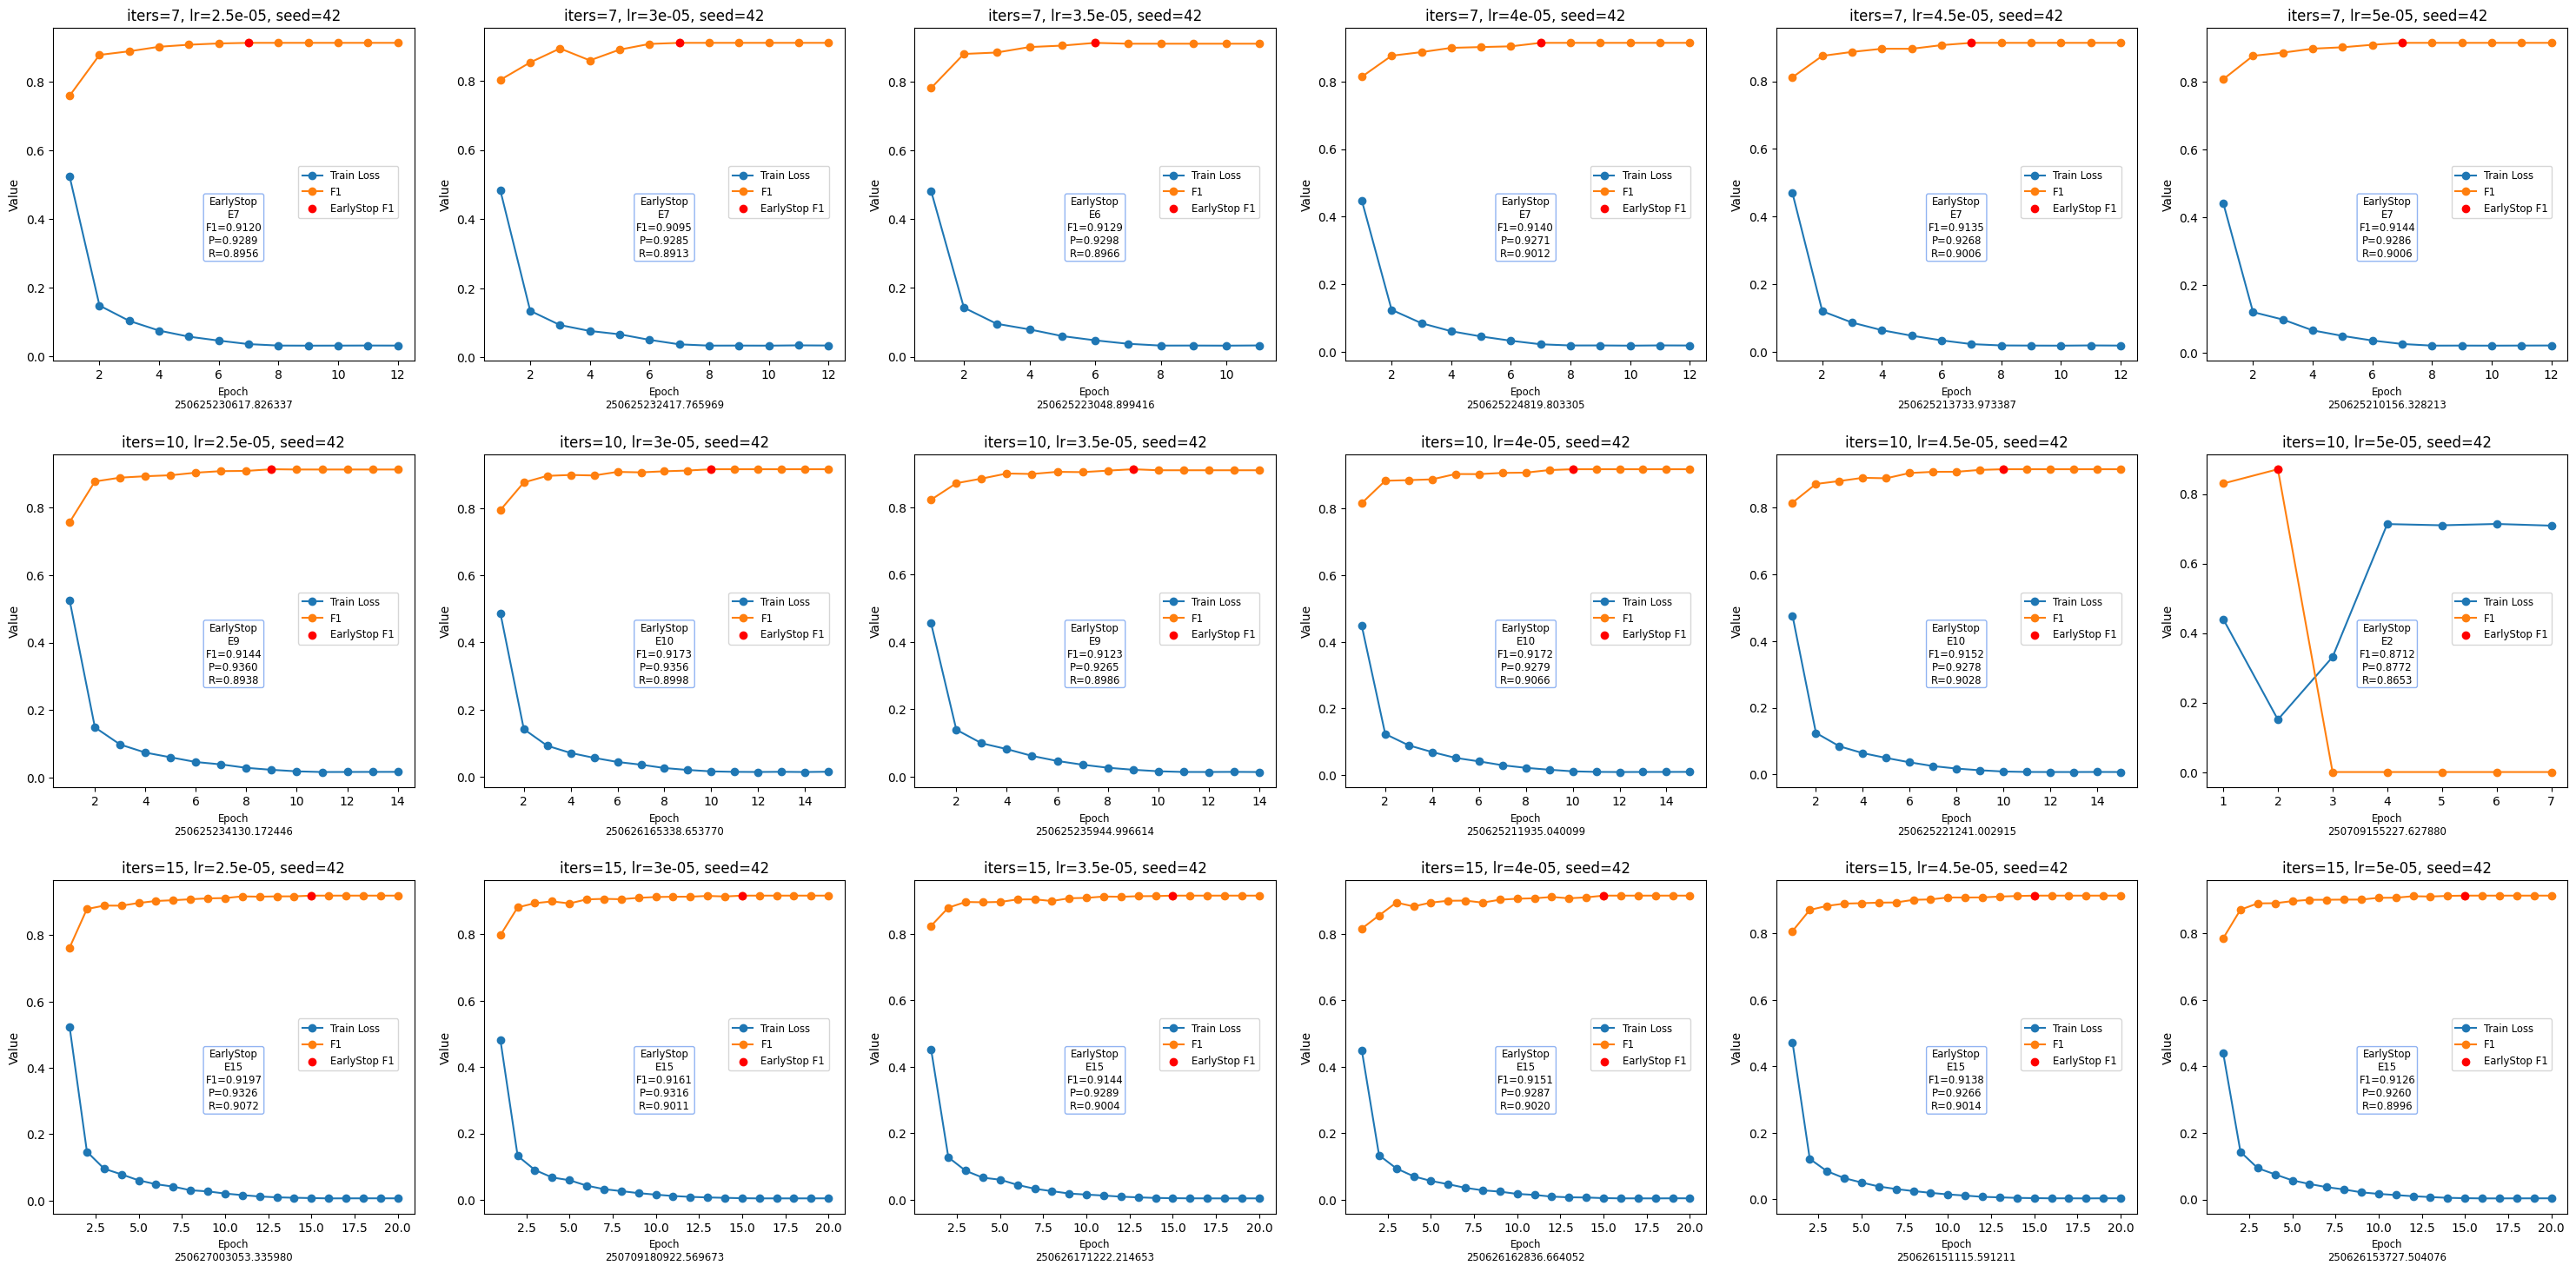


========= Top 3 experiments (by Early Stopping, patience=5) =========
1. Directory:       250627003053.335980
   Config: iters=15, lr=2.5e-05, seed=42, epoch=15
   Valid Precision: 0.9326
   Valid Recall:    0.9072
   Valid F1:        0.9197
2. Directory:       250626165338.653770
   Config: iters=10, lr=3e-05, seed=42, epoch=10
   Valid Precision: 0.9356
   Valid Recall:    0.8998
   Valid F1:        0.9173
3. Directory:       250625211935.040099
   Config: iters=10, lr=4e-05, seed=42, epoch=10
   Valid Precision: 0.9279
   Valid Recall:    0.9066
   Valid F1:        0.9172


In [15]:
import os
import json
import yaml
import math
import matplotlib.pyplot as plt

# ========== Config ==========
experiments_dir = '../experiments1/gp_xlmroberta_large'
patience = 5

# ========== Helper function ==========
def get_cfg_info(dpath):
    cfg_path = os.path.join(dpath, 'config.yaml')
    cfg = yaml.safe_load(open(cfg_path))
    # Get total iterations & learning rate
    if 'lr_scheduler' in cfg:
        iters = cfg['lr_scheduler']['total_iters']
        lr = cfg['optimizer']['lr']
    else:
        iters = cfg['train']['lr_scheduler']['total_iters']
        lr = cfg['train']['optimizer']['lr']
    # Get seed: priority experiment.seed > top-level seed > train.seed
    seed = None
    if 'experiment' in cfg and 'seed' in cfg['experiment']:
        seed = cfg['experiment']['seed']
    elif 'seed' in cfg:
        seed = cfg['seed']
    elif 'train' in cfg and 'seed' in cfg['train']:
        seed = cfg['train']['seed']
    return iters, lr, seed

# ========== Scan valid experiment subdirectories ==========
dir_infos = []
for d in sorted(os.listdir(experiments_dir)):
    dpath = os.path.join(experiments_dir, d)
    mpath = os.path.join(dpath, 'metrics.json')
    if not (d[0].isdigit() and os.path.isdir(dpath) and os.path.exists(mpath)):
        continue
    with open(mpath) as f:
        recs = [json.loads(line) for line in f if line.strip()]
    if any(r.get('mode') == 'eval' for r in recs):
        iters, lr, seed = get_cfg_info(dpath)
        dir_infos.append((d, iters, lr, seed))
# Sort by iters, lr, seed (None last)
dir_infos_sorted = sorted(
    dir_infos,
    key=lambda x: (x[1], x[2], x[3] if x[3] is not None else float('inf'))
)

# ========== Plotting setup ==========
valid_dirs = [x[0] for x in dir_infos_sorted]
n = len(valid_dirs)
cols = 6
rows = math.ceil(n / cols)
fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 5))
axes = axes.flatten()

# Collect EarlyStop info for each experiment
esf1_infos = []

for ax, (d, iters, lr, seed) in zip(axes, dir_infos_sorted):
    dpath = os.path.join(experiments_dir, d)
    metrics = [json.loads(line) for line in open(os.path.join(dpath, 'metrics.json')) if line.strip()]
    # Extract epochs
    epochs = sorted({m['epoch'] for m in metrics if m['mode'] == 'train'})
    train_losses = []
    val_f1s = []
    for e in epochs:
        train_losses.append(
            sum(m['loss'] for m in metrics if m['mode'] == 'train' and m['epoch'] == e) /
            max(1, len([m for m in metrics if m['mode'] == 'train' and m['epoch'] == e]))
        )
        f1_list = [m['evaluation/f1'] for m in metrics if m['mode'] == 'eval' and m['epoch'] == e]
        val_f1s.append(f1_list[0] if f1_list else None)

    # Early stopping based on patience
    best_f1_es = -1.0
    patience_counter = 0
    best_epoch_es = epochs[0]
    for i, f1 in enumerate(val_f1s):
        if f1 is not None and f1 > best_f1_es:
            best_f1_es = f1
            best_epoch_es = epochs[i]
            patience_counter = 0
        else:
            patience_counter += 1
        if patience_counter >= patience:
            break

    # Record metrics at best_epoch_es
    es_record = next(m for m in metrics if m['mode'] == 'eval' and m['epoch'] == best_epoch_es)
    vp_es = es_record['evaluation/precision']
    vr_es = es_record['evaluation/recall']
    vf_es = es_record['evaluation/f1']

    # Append this experiment's info
    esf1_infos.append({
        'dir':       d,
        'iters':     iters,
        'lr':        lr,
        'seed':      seed,
        'epoch':     best_epoch_es,
        'precision': vp_es,
        'recall':    vr_es,
        'f1':        vf_es
    })

    # Plot training loss and validation F1
    max_epoch_to_plot = best_epoch_es + patience
    plot_epochs = [e for e in epochs if e <= max_epoch_to_plot]
    plot_train = [train_losses[epochs.index(e)] for e in plot_epochs]
    plot_val = [val_f1s[epochs.index(e)] for e in plot_epochs]

    ax.plot(plot_epochs, plot_train, marker='o', label='Train Loss')
    ax.plot(plot_epochs, plot_val, marker='o', label='F1')
    ax.scatter(best_epoch_es, vf_es, zorder=5, label='EarlyStop F1', color='red')
    ax.annotate(
        f"EarlyStop\nE{best_epoch_es}\nF1={vf_es:.4f}\nP={vp_es:.4f}\nR={vr_es:.4f}",
        xy=(0.5, 0.4), xycoords='axes fraction',
        ha='center', va='center', fontsize='small',
        bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="cornflowerblue", alpha=0.7)
    )
    ax.set_title(f"iters={iters}, lr={lr}, seed={seed}")
    ax.set_xlabel(f'Epoch\n{d}', fontsize='small', labelpad=4)
    ax.set_ylabel('Value')
    ax.legend(loc='upper right', bbox_to_anchor=(0.97, 0.6), fontsize='small')

# Turn off extra axes
for ax in axes[len(valid_dirs):]:
    ax.axis('off')

plt.subplots_adjust(top=0.88, hspace=0.5, wspace=0.3)
plt.tight_layout(pad=2)
plt.show()

# ========== Print Top 3 Experiments ==========
print(f"\n========= Top 3 experiments (by Early Stopping, patience={patience}) =========")
top3 = sorted(esf1_infos, key=lambda x: x['f1'], reverse=True)[:3]
for rank, info in enumerate(top3, start=1):
    print(f"{rank}. Directory:       {info['dir']}")
    print(f"   Config: iters={info['iters']}, lr={info['lr']}, seed={info['seed']}, epoch={info['epoch']}")
    print(f"   Valid Precision: {info['precision']:.4f}")
    print(f"   Valid Recall:    {info['recall']:.4f}")
    print(f"   Valid F1:        {info['f1']:.4f}")


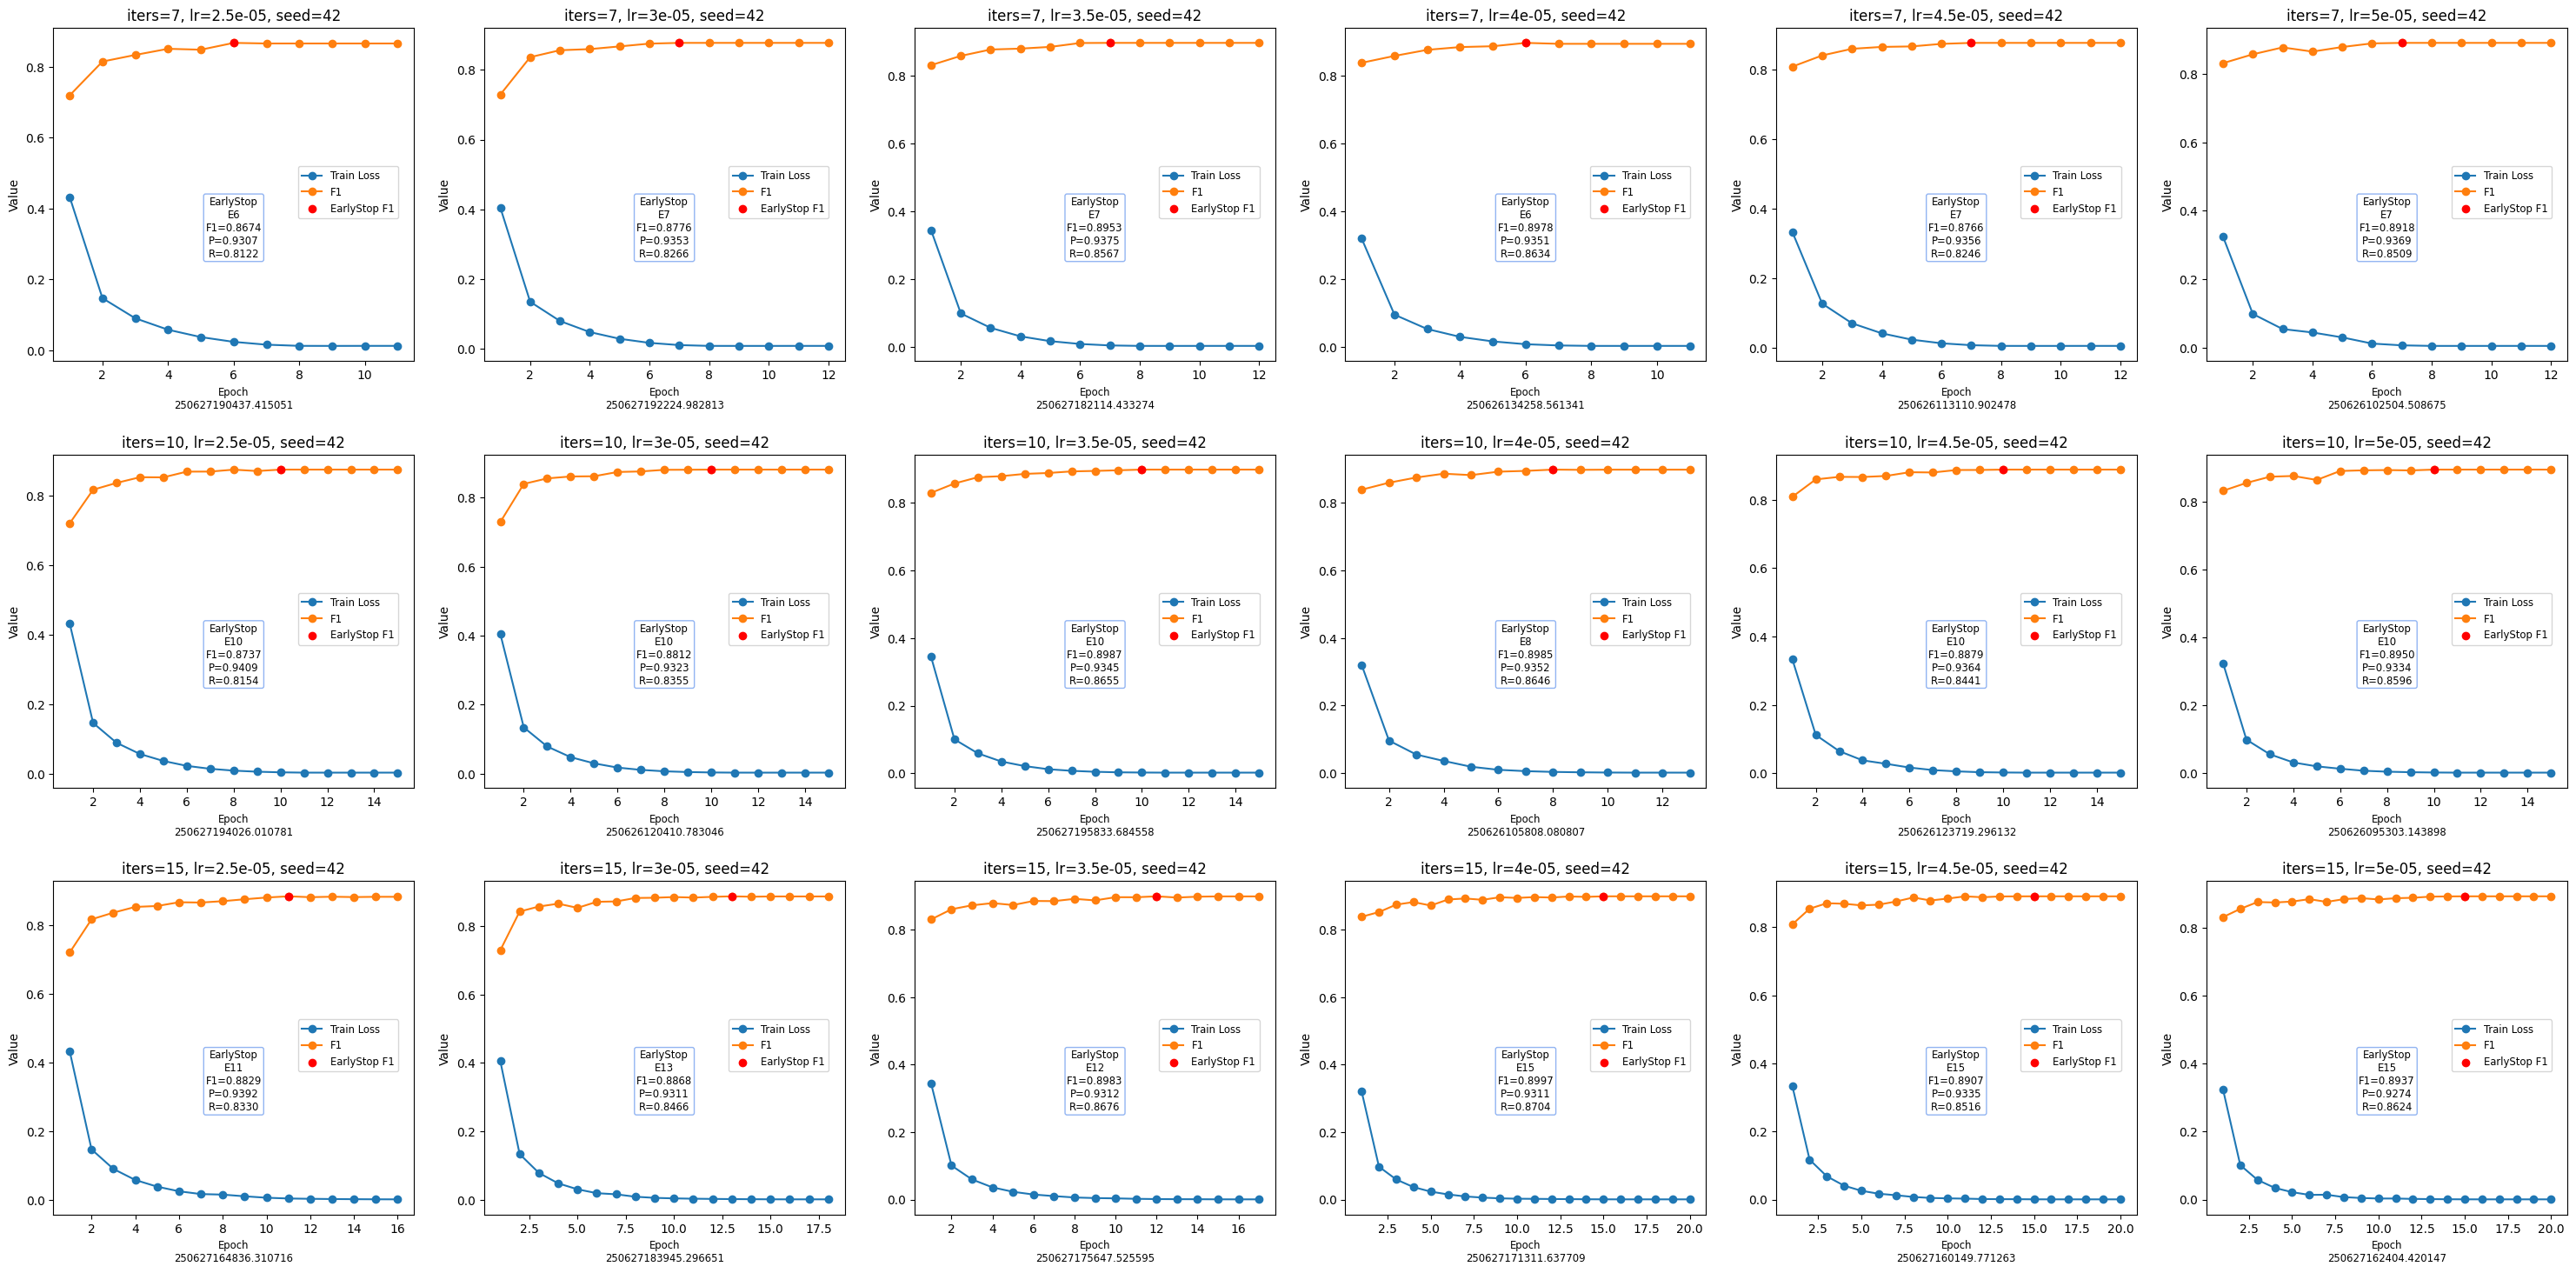


========= Top 3 experiments (by Early Stopping, patience=5) =========
1. Directory:       250627171311.637709
   Config: iters=15, lr=4e-05, seed=42, epoch=15
   Valid Precision: 0.9311
   Valid Recall:    0.8704
   Valid F1:        0.8997
2. Directory:       250627195833.684558
   Config: iters=10, lr=3.5e-05, seed=42, epoch=10
   Valid Precision: 0.9345
   Valid Recall:    0.8655
   Valid F1:        0.8987
3. Directory:       250626105808.080807
   Config: iters=10, lr=4e-05, seed=42, epoch=8
   Valid Precision: 0.9352
   Valid Recall:    0.8646
   Valid F1:        0.8985


In [11]:
import os
import json
import yaml
import math
import matplotlib.pyplot as plt

# ========== Config ==========
experiments_dir = '../experiments1/gp_modernbert_large'
patience = 5

# ========== Helper function ==========
def get_cfg_info(dpath):
    cfg_path = os.path.join(dpath, 'config.yaml')
    cfg = yaml.safe_load(open(cfg_path))
    # Get total iterations & learning rate
    if 'lr_scheduler' in cfg:
        iters = cfg['lr_scheduler']['total_iters']
        lr = cfg['optimizer']['lr']
    else:
        iters = cfg['train']['lr_scheduler']['total_iters']
        lr = cfg['train']['optimizer']['lr']
    # Get seed: priority experiment.seed > top-level seed > train.seed
    seed = None
    if 'experiment' in cfg and 'seed' in cfg['experiment']:
        seed = cfg['experiment']['seed']
    elif 'seed' in cfg:
        seed = cfg['seed']
    elif 'train' in cfg and 'seed' in cfg['train']:
        seed = cfg['train']['seed']
    return iters, lr, seed

# ========== Scan valid experiment subdirectories ==========
dir_infos = []
for d in sorted(os.listdir(experiments_dir)):
    dpath = os.path.join(experiments_dir, d)
    mpath = os.path.join(dpath, 'metrics.json')
    if not (d[0].isdigit() and os.path.isdir(dpath) and os.path.exists(mpath)):
        continue
    with open(mpath) as f:
        recs = [json.loads(line) for line in f if line.strip()]
    if any(r.get('mode') == 'eval' for r in recs):
        iters, lr, seed = get_cfg_info(dpath)
        dir_infos.append((d, iters, lr, seed))
# Sort by iters, lr, seed (None last)
dir_infos_sorted = sorted(
    dir_infos,
    key=lambda x: (x[1], x[2], x[3] if x[3] is not None else float('inf'))
)

# ========== Plotting setup ==========
valid_dirs = [x[0] for x in dir_infos_sorted]
n = len(valid_dirs)
cols = 6
rows = math.ceil(n / cols)
fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 5))
axes = axes.flatten()

# Collect EarlyStop info for each experiment
esf1_infos = []

for ax, (d, iters, lr, seed) in zip(axes, dir_infos_sorted):
    dpath = os.path.join(experiments_dir, d)
    metrics = [json.loads(line) for line in open(os.path.join(dpath, 'metrics.json')) if line.strip()]
    # Extract epochs
    epochs = sorted({m['epoch'] for m in metrics if m['mode'] == 'train'})
    train_losses = []
    val_f1s = []
    for e in epochs:
        train_losses.append(
            sum(m['loss'] for m in metrics if m['mode'] == 'train' and m['epoch'] == e) /
            max(1, len([m for m in metrics if m['mode'] == 'train' and m['epoch'] == e]))
        )
        f1_list = [m['evaluation/f1'] for m in metrics if m['mode'] == 'eval' and m['epoch'] == e]
        val_f1s.append(f1_list[0] if f1_list else None)

    # Early stopping based on patience
    best_f1_es = -1.0
    patience_counter = 0
    best_epoch_es = epochs[0]
    for i, f1 in enumerate(val_f1s):
        if f1 is not None and f1 > best_f1_es:
            best_f1_es = f1
            best_epoch_es = epochs[i]
            patience_counter = 0
        else:
            patience_counter += 1
        if patience_counter >= patience:
            break

    # Record metrics at best_epoch_es
    es_record = next(m for m in metrics if m['mode'] == 'eval' and m['epoch'] == best_epoch_es)
    vp_es = es_record['evaluation/precision']
    vr_es = es_record['evaluation/recall']
    vf_es = es_record['evaluation/f1']

    # Append this experiment's info
    esf1_infos.append({
        'dir':       d,
        'iters':     iters,
        'lr':        lr,
        'seed':      seed,
        'epoch':     best_epoch_es,
        'precision': vp_es,
        'recall':    vr_es,
        'f1':        vf_es
    })

    # Plot training loss and validation F1
    max_epoch_to_plot = best_epoch_es + patience
    plot_epochs = [e for e in epochs if e <= max_epoch_to_plot]
    plot_train = [train_losses[epochs.index(e)] for e in plot_epochs]
    plot_val = [val_f1s[epochs.index(e)] for e in plot_epochs]

    ax.plot(plot_epochs, plot_train, marker='o', label='Train Loss')
    ax.plot(plot_epochs, plot_val, marker='o', label='F1')
    ax.scatter(best_epoch_es, vf_es, zorder=5, label='EarlyStop F1', color='red')
    ax.annotate(
        f"EarlyStop\nE{best_epoch_es}\nF1={vf_es:.4f}\nP={vp_es:.4f}\nR={vr_es:.4f}",
        xy=(0.5, 0.4), xycoords='axes fraction',
        ha='center', va='center', fontsize='small',
        bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="cornflowerblue", alpha=0.7)
    )
    ax.set_title(f"iters={iters}, lr={lr}, seed={seed}")
    ax.set_xlabel(f'Epoch\n{d}', fontsize='small', labelpad=4)
    ax.set_ylabel('Value')
    ax.legend(loc='upper right', bbox_to_anchor=(0.97, 0.6), fontsize='small')

# Turn off extra axes
for ax in axes[len(valid_dirs):]:
    ax.axis('off')

plt.subplots_adjust(top=0.88, hspace=0.5, wspace=0.3)
plt.tight_layout(pad=2)
plt.show()

# ========== Print Top 3 Experiments ==========
print(f"\n========= Top 3 experiments (by Early Stopping, patience={patience}) =========")
top3 = sorted(esf1_infos, key=lambda x: x['f1'], reverse=True)[:3]
for rank, info in enumerate(top3, start=1):
    print(f"{rank}. Directory:       {info['dir']}")
    print(f"   Config: iters={info['iters']}, lr={info['lr']}, seed={info['seed']}, epoch={info['epoch']}")
    print(f"   Valid Precision: {info['precision']:.4f}")
    print(f"   Valid Recall:    {info['recall']:.4f}")
    print(f"   Valid F1:        {info['f1']:.4f}")


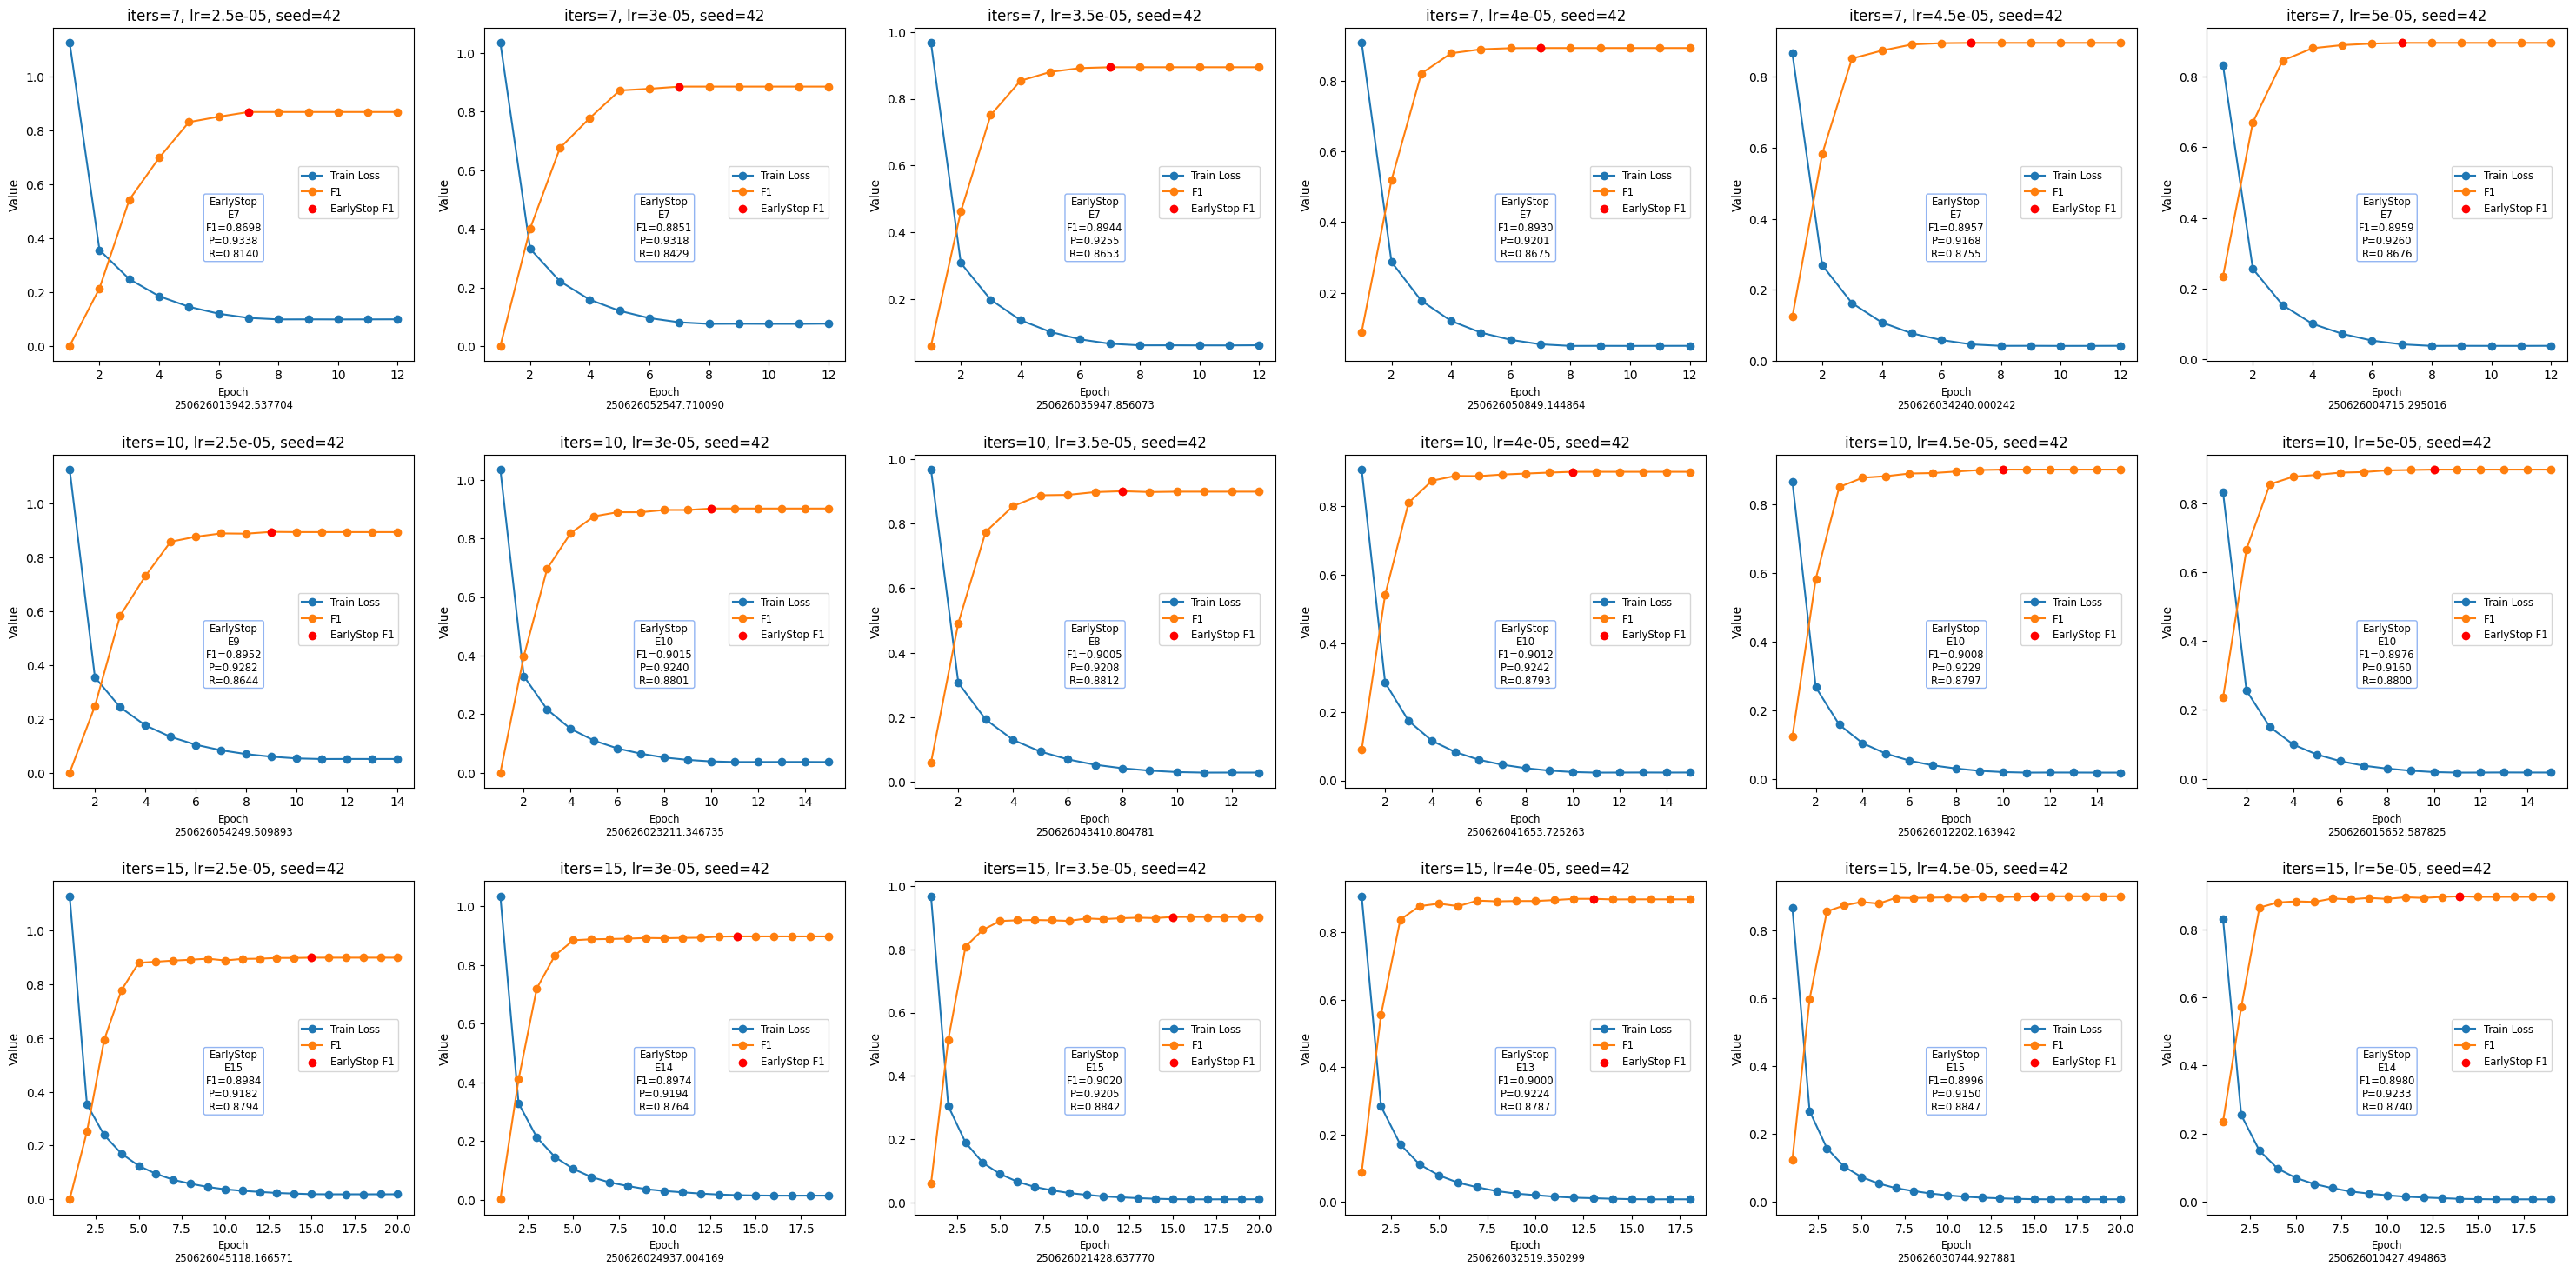


========= Top 3 experiments (by Early Stopping, patience=5) =========
1. Directory:       250626021428.637770
   Config: iters=15, lr=3.5e-05, seed=42, epoch=15
   Valid Precision: 0.9205
   Valid Recall:    0.8842
   Valid F1:        0.9020
2. Directory:       250626023211.346735
   Config: iters=10, lr=3e-05, seed=42, epoch=10
   Valid Precision: 0.9240
   Valid Recall:    0.8801
   Valid F1:        0.9015
3. Directory:       250626041653.725263
   Config: iters=10, lr=4e-05, seed=42, epoch=10
   Valid Precision: 0.9242
   Valid Recall:    0.8793
   Valid F1:        0.9012


In [17]:
import os
import json
import yaml
import math
import matplotlib.pyplot as plt

# ========== Config ==========
experiments_dir = '../experiments1/gp_spanbert'
patience = 5

# ========== Helper function ==========
def get_cfg_info(dpath):
    cfg_path = os.path.join(dpath, 'config.yaml')
    cfg = yaml.safe_load(open(cfg_path))
    # Get total iterations & learning rate
    if 'lr_scheduler' in cfg:
        iters = cfg['lr_scheduler']['total_iters']
        lr = cfg['optimizer']['lr']
    else:
        iters = cfg['train']['lr_scheduler']['total_iters']
        lr = cfg['train']['optimizer']['lr']
    # Get seed: priority experiment.seed > top-level seed > train.seed
    seed = None
    if 'experiment' in cfg and 'seed' in cfg['experiment']:
        seed = cfg['experiment']['seed']
    elif 'seed' in cfg:
        seed = cfg['seed']
    elif 'train' in cfg and 'seed' in cfg['train']:
        seed = cfg['train']['seed']
    return iters, lr, seed

# ========== Scan valid experiment subdirectories ==========
dir_infos = []
for d in sorted(os.listdir(experiments_dir)):
    dpath = os.path.join(experiments_dir, d)
    mpath = os.path.join(dpath, 'metrics.json')
    if not (d[0].isdigit() and os.path.isdir(dpath) and os.path.exists(mpath)):
        continue
    with open(mpath) as f:
        recs = [json.loads(line) for line in f if line.strip()]
    if any(r.get('mode') == 'eval' for r in recs):
        iters, lr, seed = get_cfg_info(dpath)
        dir_infos.append((d, iters, lr, seed))
# Sort by iters, lr, seed (None last)
dir_infos_sorted = sorted(
    dir_infos,
    key=lambda x: (x[1], x[2], x[3] if x[3] is not None else float('inf'))
)

# ========== Plotting setup ==========
valid_dirs = [x[0] for x in dir_infos_sorted]
n = len(valid_dirs)
cols = 6
rows = math.ceil(n / cols)
fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 5))
axes = axes.flatten()

# Collect EarlyStop info for each experiment
esf1_infos = []

for ax, (d, iters, lr, seed) in zip(axes, dir_infos_sorted):
    dpath = os.path.join(experiments_dir, d)
    metrics = [json.loads(line) for line in open(os.path.join(dpath, 'metrics.json')) if line.strip()]
    # Extract epochs
    epochs = sorted({m['epoch'] for m in metrics if m['mode'] == 'train'})
    train_losses = []
    val_f1s = []
    for e in epochs:
        train_losses.append(
            sum(m['loss'] for m in metrics if m['mode'] == 'train' and m['epoch'] == e) /
            max(1, len([m for m in metrics if m['mode'] == 'train' and m['epoch'] == e]))
        )
        f1_list = [m['evaluation/f1'] for m in metrics if m['mode'] == 'eval' and m['epoch'] == e]
        val_f1s.append(f1_list[0] if f1_list else None)

    # Early stopping based on patience
    best_f1_es = -1.0
    patience_counter = 0
    best_epoch_es = epochs[0]
    for i, f1 in enumerate(val_f1s):
        if f1 is not None and f1 > best_f1_es:
            best_f1_es = f1
            best_epoch_es = epochs[i]
            patience_counter = 0
        else:
            patience_counter += 1
        if patience_counter >= patience:
            break

    # Record metrics at best_epoch_es
    es_record = next(m for m in metrics if m['mode'] == 'eval' and m['epoch'] == best_epoch_es)
    vp_es = es_record['evaluation/precision']
    vr_es = es_record['evaluation/recall']
    vf_es = es_record['evaluation/f1']

    # Append this experiment's info
    esf1_infos.append({
        'dir':       d,
        'iters':     iters,
        'lr':        lr,
        'seed':      seed,
        'epoch':     best_epoch_es,
        'precision': vp_es,
        'recall':    vr_es,
        'f1':        vf_es
    })

    # Plot training loss and validation F1
    max_epoch_to_plot = best_epoch_es + patience
    plot_epochs = [e for e in epochs if e <= max_epoch_to_plot]
    plot_train = [train_losses[epochs.index(e)] for e in plot_epochs]
    plot_val = [val_f1s[epochs.index(e)] for e in plot_epochs]

    ax.plot(plot_epochs, plot_train, marker='o', label='Train Loss')
    ax.plot(plot_epochs, plot_val, marker='o', label='F1')
    ax.scatter(best_epoch_es, vf_es, zorder=5, label='EarlyStop F1', color='red')
    ax.annotate(
        f"EarlyStop\nE{best_epoch_es}\nF1={vf_es:.4f}\nP={vp_es:.4f}\nR={vr_es:.4f}",
        xy=(0.5, 0.4), xycoords='axes fraction',
        ha='center', va='center', fontsize='small',
        bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="cornflowerblue", alpha=0.7)
    )
    ax.set_title(f"iters={iters}, lr={lr}, seed={seed}")
    ax.set_xlabel(f'Epoch\n{d}', fontsize='small', labelpad=4)
    ax.set_ylabel('Value')
    ax.legend(loc='upper right', bbox_to_anchor=(0.97, 0.6), fontsize='small')

# Turn off extra axes
for ax in axes[len(valid_dirs):]:
    ax.axis('off')

plt.subplots_adjust(top=0.88, hspace=0.5, wspace=0.3)
plt.tight_layout(pad=2)
plt.show()

# ========== Print Top 3 Experiments ==========
print(f"\n========= Top 3 experiments (by Early Stopping, patience={patience}) =========")
top3 = sorted(esf1_infos, key=lambda x: x['f1'], reverse=True)[:3]
for rank, info in enumerate(top3, start=1):
    print(f"{rank}. Directory:       {info['dir']}")
    print(f"   Config: iters={info['iters']}, lr={info['lr']}, seed={info['seed']}, epoch={info['epoch']}")
    print(f"   Valid Precision: {info['precision']:.4f}")
    print(f"   Valid Recall:    {info['recall']:.4f}")
    print(f"   Valid F1:        {info['f1']:.4f}")


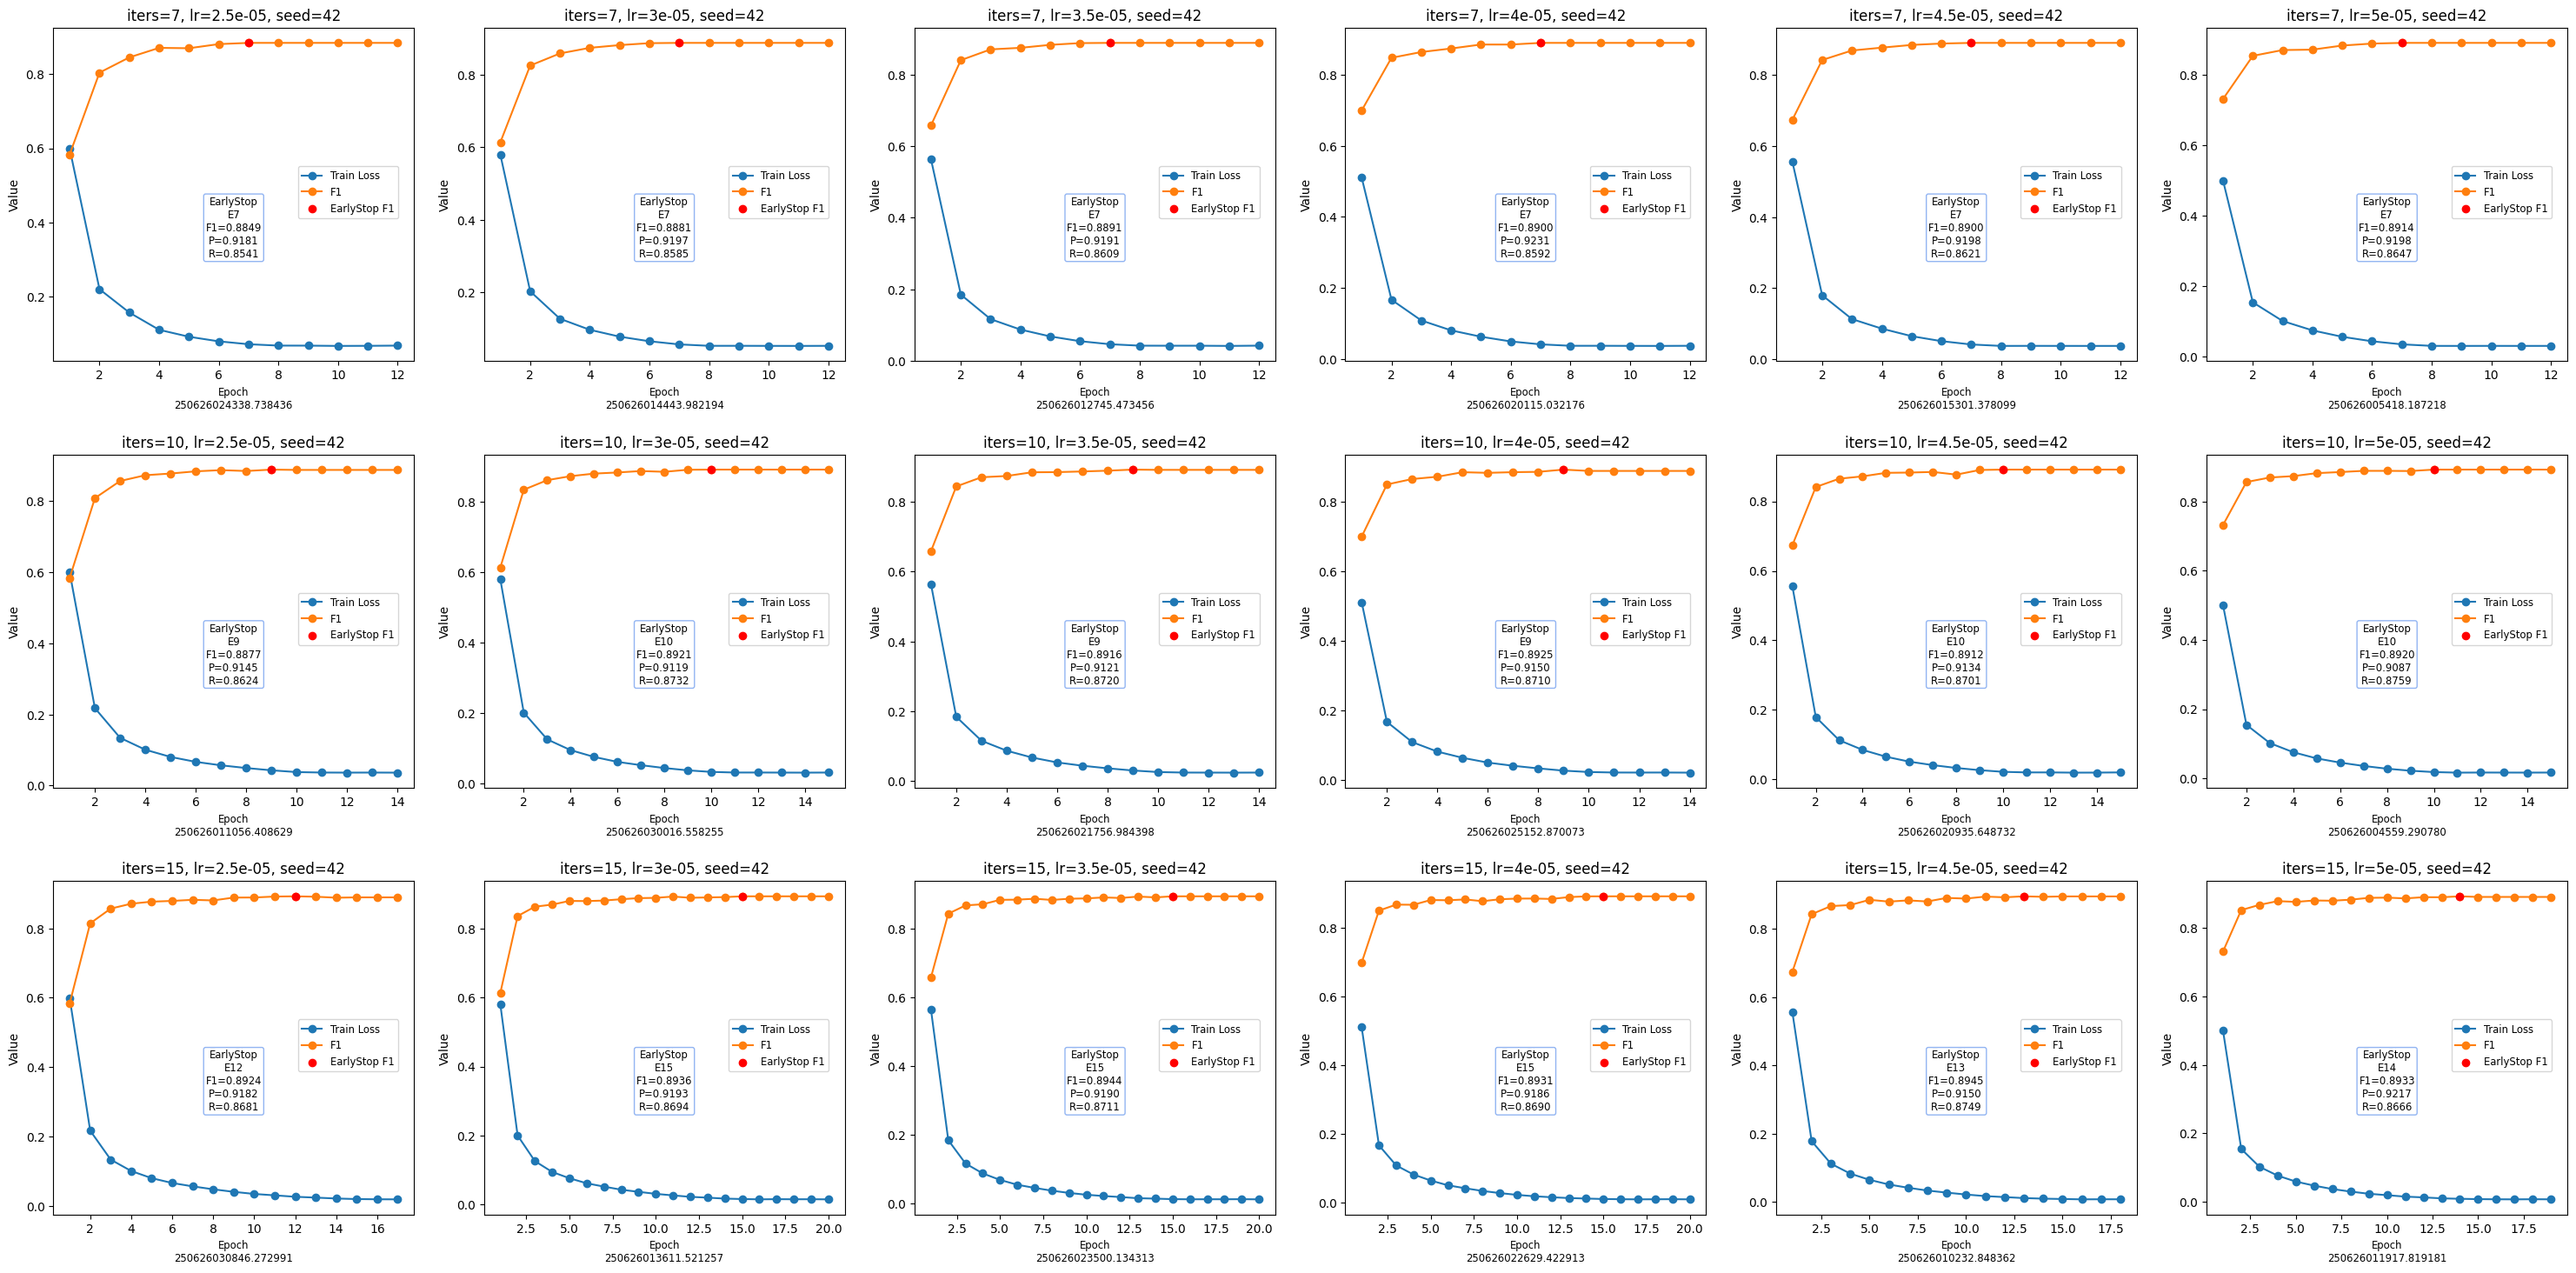


========= Top 3 experiments (by Early Stopping, patience=5) =========
1. Directory:       250626010232.848362
   Config: iters=15, lr=4.5e-05, seed=42, epoch=13
   Valid Precision: 0.9150
   Valid Recall:    0.8749
   Valid F1:        0.8945
2. Directory:       250626023500.134313
   Config: iters=15, lr=3.5e-05, seed=42, epoch=15
   Valid Precision: 0.9190
   Valid Recall:    0.8711
   Valid F1:        0.8944
3. Directory:       250626013611.521257
   Config: iters=15, lr=3e-05, seed=42, epoch=15
   Valid Precision: 0.9193
   Valid Recall:    0.8694
   Valid F1:        0.8936


In [19]:
import os
import json
import yaml
import math
import matplotlib.pyplot as plt

# ========== Config ==========
experiments_dir = '../experiments1/gp_LUKE'
patience = 5

# ========== Helper function ==========
def get_cfg_info(dpath):
    cfg_path = os.path.join(dpath, 'config.yaml')
    cfg = yaml.safe_load(open(cfg_path))
    # Get total iterations & learning rate
    if 'lr_scheduler' in cfg:
        iters = cfg['lr_scheduler']['total_iters']
        lr = cfg['optimizer']['lr']
    else:
        iters = cfg['train']['lr_scheduler']['total_iters']
        lr = cfg['train']['optimizer']['lr']
    # Get seed: priority experiment.seed > top-level seed > train.seed
    seed = None
    if 'experiment' in cfg and 'seed' in cfg['experiment']:
        seed = cfg['experiment']['seed']
    elif 'seed' in cfg:
        seed = cfg['seed']
    elif 'train' in cfg and 'seed' in cfg['train']:
        seed = cfg['train']['seed']
    return iters, lr, seed

# ========== Scan valid experiment subdirectories ==========
dir_infos = []
for d in sorted(os.listdir(experiments_dir)):
    dpath = os.path.join(experiments_dir, d)
    mpath = os.path.join(dpath, 'metrics.json')
    if not (d[0].isdigit() and os.path.isdir(dpath) and os.path.exists(mpath)):
        continue
    with open(mpath) as f:
        recs = [json.loads(line) for line in f if line.strip()]
    if any(r.get('mode') == 'eval' for r in recs):
        iters, lr, seed = get_cfg_info(dpath)
        dir_infos.append((d, iters, lr, seed))
# Sort by iters, lr, seed (None last)
dir_infos_sorted = sorted(
    dir_infos,
    key=lambda x: (x[1], x[2], x[3] if x[3] is not None else float('inf'))
)

# ========== Plotting setup ==========
valid_dirs = [x[0] for x in dir_infos_sorted]
n = len(valid_dirs)
cols = 6
rows = math.ceil(n / cols)
fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 5))
axes = axes.flatten()

# Collect EarlyStop info for each experiment
esf1_infos = []

for ax, (d, iters, lr, seed) in zip(axes, dir_infos_sorted):
    dpath = os.path.join(experiments_dir, d)
    metrics = [json.loads(line) for line in open(os.path.join(dpath, 'metrics.json')) if line.strip()]
    # Extract epochs
    epochs = sorted({m['epoch'] for m in metrics if m['mode'] == 'train'})
    train_losses = []
    val_f1s = []
    for e in epochs:
        train_losses.append(
            sum(m['loss'] for m in metrics if m['mode'] == 'train' and m['epoch'] == e) /
            max(1, len([m for m in metrics if m['mode'] == 'train' and m['epoch'] == e]))
        )
        f1_list = [m['evaluation/f1'] for m in metrics if m['mode'] == 'eval' and m['epoch'] == e]
        val_f1s.append(f1_list[0] if f1_list else None)

    # Early stopping based on patience
    best_f1_es = -1.0
    patience_counter = 0
    best_epoch_es = epochs[0]
    for i, f1 in enumerate(val_f1s):
        if f1 is not None and f1 > best_f1_es:
            best_f1_es = f1
            best_epoch_es = epochs[i]
            patience_counter = 0
        else:
            patience_counter += 1
        if patience_counter >= patience:
            break

    # Record metrics at best_epoch_es
    es_record = next(m for m in metrics if m['mode'] == 'eval' and m['epoch'] == best_epoch_es)
    vp_es = es_record['evaluation/precision']
    vr_es = es_record['evaluation/recall']
    vf_es = es_record['evaluation/f1']

    # Append this experiment's info
    esf1_infos.append({
        'dir':       d,
        'iters':     iters,
        'lr':        lr,
        'seed':      seed,
        'epoch':     best_epoch_es,
        'precision': vp_es,
        'recall':    vr_es,
        'f1':        vf_es
    })

    # Plot training loss and validation F1
    max_epoch_to_plot = best_epoch_es + patience
    plot_epochs = [e for e in epochs if e <= max_epoch_to_plot]
    plot_train = [train_losses[epochs.index(e)] for e in plot_epochs]
    plot_val = [val_f1s[epochs.index(e)] for e in plot_epochs]

    ax.plot(plot_epochs, plot_train, marker='o', label='Train Loss')
    ax.plot(plot_epochs, plot_val, marker='o', label='F1')
    ax.scatter(best_epoch_es, vf_es, zorder=5, label='EarlyStop F1', color='red')
    ax.annotate(
        f"EarlyStop\nE{best_epoch_es}\nF1={vf_es:.4f}\nP={vp_es:.4f}\nR={vr_es:.4f}",
        xy=(0.5, 0.4), xycoords='axes fraction',
        ha='center', va='center', fontsize='small',
        bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="cornflowerblue", alpha=0.7)
    )
    ax.set_title(f"iters={iters}, lr={lr}, seed={seed}")
    ax.set_xlabel(f'Epoch\n{d}', fontsize='small', labelpad=4)
    ax.set_ylabel('Value')
    ax.legend(loc='upper right', bbox_to_anchor=(0.97, 0.6), fontsize='small')

# Turn off extra axes
for ax in axes[len(valid_dirs):]:
    ax.axis('off')

plt.subplots_adjust(top=0.88, hspace=0.5, wspace=0.3)
plt.tight_layout(pad=2)
plt.show()

# ========== Print Top 3 Experiments ==========
print(f"\n========= Top 3 experiments (by Early Stopping, patience={patience}) =========")
top3 = sorted(esf1_infos, key=lambda x: x['f1'], reverse=True)[:3]
for rank, info in enumerate(top3, start=1):
    print(f"{rank}. Directory:       {info['dir']}")
    print(f"   Config: iters={info['iters']}, lr={info['lr']}, seed={info['seed']}, epoch={info['epoch']}")
    print(f"   Valid Precision: {info['precision']:.4f}")
    print(f"   Valid Recall:    {info['recall']:.4f}")
    print(f"   Valid F1:        {info['f1']:.4f}")
